The visualization notebook includes code for generating some of the visualizations used in the project, the dummy model, and the baseline SVM model.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
#from IPython.display import display, Image
from scipy.ndimage import imread
import os, shutil
import sys
import random
import time
import pickle
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.callbacks import ModelCheckpoint  
from keras import applications
import random
from PIL import Image
from scipy.stats import sem
%matplotlib inline
#if K.image_data_format() == 'channels_first':
#    input_shape = (3, img_width, img_height)
#else:
#    input_shape = (img_width, img_height, 3)

Using TensorFlow backend.


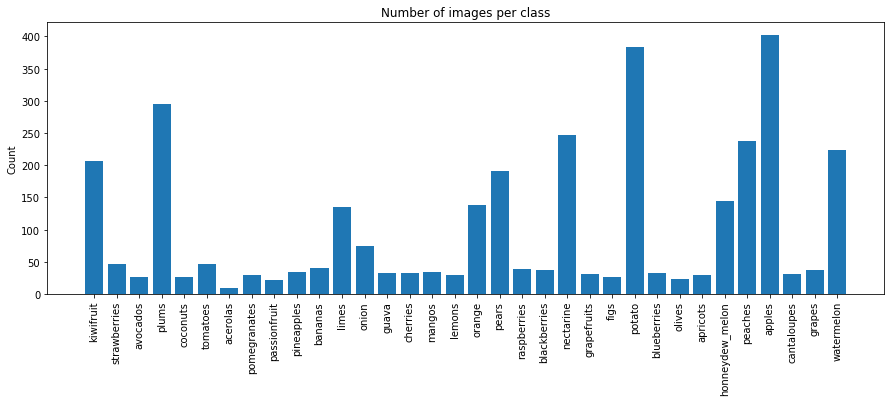

In [2]:
# create a dict to hold the class weights
class_weight= dict()
# loop through the folders containing the images, use the folder name as the key
for folders in os.listdir('data'):
    for label in os.listdir('data/'+folders):
        if label in class_weight.keys():
            class_weight[label] += len(os.listdir('data/'+folders+'/'+label))
        else:
            class_weight[label] = len(os.listdir('data/'+folders+'/'+label))
# plot items in each class before normalizing values
fig, ax = plt.subplots(figsize=(15,5))
plt.bar(range(len(class_weight)), class_weight.values(), align='center')
plt.xticks(range(len(class_weight)), list(class_weight.keys()))
ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Count')
plt.title('Number of images per class')
plt.show()

In [3]:
sum(class_weight.values())

3373

## Dummy classifier
Find the majority of class in the training set, then predict only that class on the validation set. Dummy accuracy is # of majority class / # in validation set

In [4]:
train_set = dict()
for label in os.listdir('data/train'):
    if label in train_set.keys():
        train_set[label] += len(os.listdir('data/train/'+label))
    else:
        train_set[label] = len(os.listdir('data/train/'+label))
print(max(train_set, key=lambda key: train_set[key]))
print(train_set['apples'])
num_train_maj = train_set['apples']

apples
241


In [5]:
valid_set = dict()
for label in os.listdir('data/valid'):
    if label in valid_set.keys():
        valid_set[label] += len(os.listdir('data/valid/'+label))
    else:
        valid_set[label] = len(os.listdir('data/valid/'+label))
print(sum(valid_set.values()))
num_valid = sum(valid_set.values())

675


In [6]:
dummy_acc = num_train_maj / num_valid
print(dummy_acc)

0.35703703703703704


## Benchmark: SVM
load each image as a vector of pixels
train SVM
score on validation set

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
from sklearn import preprocessing

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    fruit_files = np.array(data['filenames'])
    le = preprocessing.LabelEncoder()
    fruit_targets = le.fit_transform(np.array(data['target']))
    return fruit_files, fruit_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('data/train')
valid_files, valid_targets = load_dataset('data/valid')
test_files, test_targets = load_dataset('data/test')

# load list of dog names
fruit_names = [item[11:-1] for item in sorted(glob("data/train/*/"))]

# print statistics about the dataset
print('There are %d total fruit categories.' % len(fruit_names))
print('There are %s total fruit images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training fruit images.' % len(train_files))
print('There are %d validation fruit images.' % len(valid_files))
print('There are %d test fruit images.'% len(test_files))

There are 34 total fruit categories.
There are 3373 total fruit images.

There are 2009 training fruit images.
There are 675 validation fruit images.
There are 689 test fruit images.


In [4]:
# assert that the correct data type
print(type(train_files))

<class 'numpy.ndarray'>


In [5]:
# function that shuffles and re-splits training and validation lists
# this function is used for each new round of training the SVM model.

# zip a and b
tr = zip(train_files,train_targets)
vld = zip(valid_files,valid_targets)
abcd = list(tr)+list(vld)
random.shuffle(abcd)
tr = abcd[:2009]
vld = abcd[2009:]
train_files, train_targets = zip(*tr)
valid_files, valid_targets = zip(*vld)
train_files = np.asarray(train_files)
train_targets = np.asarray(train_targets)
valid_files = np.asarray(valid_files)
valid_targets = np.asarray(valid_targets)

print('There are %d training fruit images.' % len(train_files))
print('There are %d validation fruit images.' % len(valid_files))

# zip a and b
tr = zip(train_files,train_targets)
vld = zip(valid_files,valid_targets)
abcd = list(tr)+list(vld)
random.shuffle(abcd)
tr = abcd[:2009]
vld = abcd[2009:]
train_files2, train_targets2 = zip(*tr)
valid_files2, valid_targets2 = zip(*vld)
train_files2 = np.asarray(train_files2)
train_targets2 = np.asarray(train_targets2)
valid_files2 = np.asarray(valid_files2)
valid_targets2 = np.asarray(valid_targets2)

print('There are %d training fruit images.' % len(train_files2))
print('There are %d validation fruit images.' % len(valid_files2))

There are 2009 training fruit images.
There are 675 validation fruit images.
There are 2009 training fruit images.
There are 675 validation fruit images.


In [6]:
# assert variables are of the right type
print(type(train_targets))
print(type(train_files))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


To create the training and validation sets for the SVM benchmark, I need several building blocks:
1. a function that resizes and image
2. a function that converts the image to a vector

[ 0.54901961  0.49411765  0.49019608 ...,  0.76470588  0.71764706
  0.75686275]


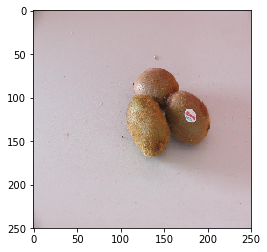

In [7]:
# convert an image to an array
def jpg_image_to_array(image_path):
    """
    Loads JPEG image into 3D Numpy array of shape 
    (width, height, channels)
    """
    with Image.open(image_path) as image:
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        try:
            im_arr = im_arr.reshape((image.size[1], image.size[0], 3))
            return im_arr
        except:
            return

def img_to_vector(im_arr):
    """
    Resizes an array representing a RGB image and returns a flattened array of the image
    """
    try:
        img = Image.fromarray(im_arr,'RGB')
        img = img.resize((250,250))
        img = np.asarray(img)/255 # normalize the images
        #print(img.shape)
        return img.flatten()#.reshape(1,-1)
    except:
        return

vec = img_to_vector(jpg_image_to_array(train_files[0]))
print(vec)
vec = vec.reshape((250,250,3))
plt.imshow(vec)
plt.show()

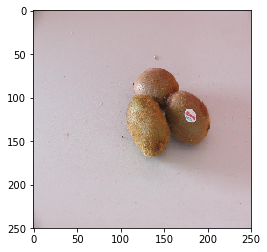

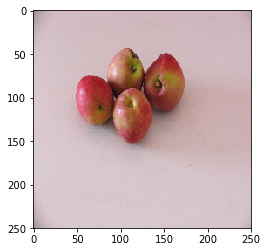

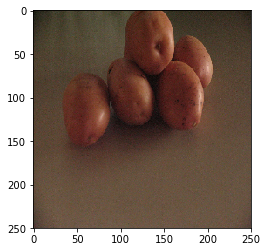

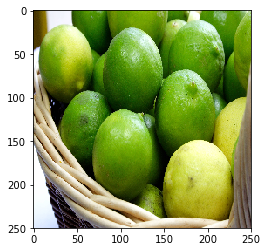

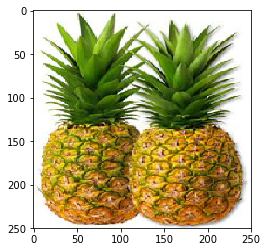

In [8]:
for i in range(5):
    img = Image.fromarray(jpg_image_to_array(train_files[i]),'RGB')
    img = img.resize((250,250))
    img = np.asarray(img)
    #print(img.flatten()[0:9]/255)
    plt.imshow(img)
    plt.show()

When initially going through this workflow, it became apparent that some of the images had some formatting issues and would need to be removed from the dataset. The cell below performs that function.

In [9]:
train_list = []
train_bads = []
for i in train_files:
    # test to make sure image can be resized
    # if not store the file name in a list
    # else append it to the list of resized images
    obs = img_to_vector(jpg_image_to_array(i))
    if obs != None:
        train_list.append(obs)
    else:
        train_bads.append(i)
        
train_list2 = []
train_bads2 = []
for i in train_files2:
    # test to make sure image can be resized
    # if not store the file name in a list
    # else append it to the list of resized images
    obs = img_to_vector(jpg_image_to_array(i))
    if obs != None:
        train_list2.append(obs)
    else:
        train_bads2.append(i)

c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  
c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [10]:
# some items were removed in the conversion of the images into the dataframe so need to remove the labels for those
# images from the train_targets list
print(train_bads)
print(np.where(train_files==train_bads[0]))
for i in train_bads:
    print(np.where(train_files==i))
    train_targets = np.delete(train_targets, np.where(train_files==i))
print(len(train_list)==len(train_targets))

# some items were removed in the conversion of the images into the dataframe so need to remove the labels for those
# images from the train_targets list
print(train_bads2)
print(np.where(train_files2==train_bads2[0]))
for i in train_bads2:
    print(np.where(train_files2==i))
    train_targets2 = np.delete(train_targets2, np.where(train_files2==i))
print(len(train_list2)==len(train_targets2))

['data/train\\cantaloupes\\7.jpg', 'data/train\\raspberries\\20.jpg', 'data/train\\blackberries\\24.jpg', 'data/valid\\guava\\28.jpg', 'data/train\\tomatoes\\38.jpg', 'data/train\\pineapples\\11.jpg', 'data/train\\bananas\\51.jpg', 'data/train\\pomegranates\\18.jpg', 'data/train\\raspberries\\11.jpg', 'data/train\\guava\\11.jpg']
(array([139], dtype=int64),)
(array([139], dtype=int64),)
(array([211], dtype=int64),)
(array([433], dtype=int64),)
(array([726], dtype=int64),)
(array([840], dtype=int64),)
(array([975], dtype=int64),)
(array([1084], dtype=int64),)
(array([1566], dtype=int64),)
(array([1640], dtype=int64),)
(array([1975], dtype=int64),)
True
['data/train\\bananas\\51.jpg', 'data/train\\blackberries\\24.jpg', 'data/train\\cantaloupes\\7.jpg', 'data/train\\pineapples\\11.jpg', 'data/train\\pomegranates\\18.jpg', 'data/train\\tomatoes\\38.jpg', 'data/train\\cherries\\10.jpg', 'data/train\\raspberries\\11.jpg', 'data/train\\guava\\11.jpg', 'data/valid\\guava\\28.jpg']
(array([239

In [11]:
print(len(train_list))
print(len(train_targets))
print(np.unique(train_targets))

print(len(train_list2))
print(len(train_targets2))
print(np.unique(train_targets2))

1999
1999
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
1999
1999
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]


In [12]:
from sklearn.svm import SVC
#class_weight='balanced'
clf = SVC(class_weight='balanced')
clf2 = SVC(class_weight='balanced')

In [13]:
print(type(train_list))

<class 'list'>


In [14]:
clf.fit(train_list, train_targets)
clf2.fit(train_list2, train_targets2)

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [15]:
valid_list = []
valid_bads = []
for i in valid_files:
    # test to make sure image can be resized
    # if not store the file name in a list
    # else append it to the list of resized images
    obs = img_to_vector(jpg_image_to_array(i))
    if obs != None:
        valid_list.append(obs)
    else:
        valid_bads.append(i)
valid_list = pd.DataFrame(valid_list)

valid_list2 = []
valid_bads2 = []
for i in valid_files2:
    # test to make sure image can be resized
    # if not store the file name in a list
    # else append it to the list of resized images
    obs = img_to_vector(jpg_image_to_array(i))
    if obs != None:
        valid_list2.append(obs)
    else:
        valid_bads2.append(i)
valid_list2 = pd.DataFrame(valid_list2)

c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  
c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [16]:
# some items were removed in the conversion of the images into the dataframe so need to remove the labels for those
# images from the train_targets list
print(valid_bads)
print(np.where(valid_files==valid_bads[0]))
for i in valid_bads:
    print(np.where(valid_files==i))
    valid_targets = np.delete(valid_targets, np.where(valid_files==i))
print(len(valid_list)==len(valid_targets))

# some items were removed in the conversion of the images into the dataframe so need to remove the labels for those
# images from the train_targets list
print(valid_bads2)
print(np.where(valid_files2==valid_bads2[0]))
for i in valid_bads2:
    print(np.where(valid_files2==i))
    valid_targets2 = np.delete(valid_targets2, np.where(valid_files2==i))
print(len(valid_list2)==len(valid_targets2))

['data/train\\cherries\\10.jpg']
(array([31], dtype=int64),)
(array([31], dtype=int64),)
True
['data/train\\raspberries\\20.jpg']
(array([441], dtype=int64),)
(array([441], dtype=int64),)
True


In [17]:
print(valid_list.shape)
print(valid_targets.shape)
print(np.unique(valid_targets))

print(valid_list2.shape)
print(valid_targets2.shape)
print(np.unique(valid_targets2))

(674, 187500)
(674,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]
(674, 187500)
(674,)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]


In [18]:
print(clf.score(valid_list, valid_targets))
print(clf2.score(valid_list2, valid_targets2))

0.428783382789
0.46884272997


In [19]:
print(type(valid_list))

<class 'pandas.core.frame.DataFrame'>


[27]
27


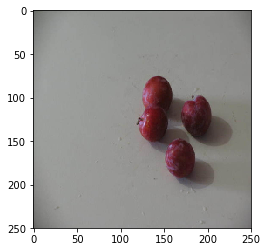

In [20]:
#print(train_list)
i=798
print(clf.predict(train_list[i].reshape(1,-1)))
print(train_targets[i])
vec = train_list[i].reshape((250,250,3))
plt.imshow(vec)
plt.show()

In [21]:
#0.3857566765578635 trial 1
#0.414925373134 trial 2
#0.41369047619 trial 3
#0.428783382789 trial 4
#0.46884272997 trial 5
svm_trials = np.asarray([0.3857566765578635,0.414925373134,0.41369047619,0.428783382789,0.46884272997])
print(svm_trials.mean())
from scipy.stats import sem
print(sem(svm_trials))

0.422399727728
0.0135501545142


In [22]:
test_list = []
test_bads = []
for i in test_files:
    # test to make sure image can be resized
    # if not store the file name in a list
    # else append it to the list of resized images
    obs = img_to_vector(jpg_image_to_array(i))
    if obs != None:
        test_list.append(obs)
    else:
        test_list.append(i)
test_list = pd.DataFrame(test_list)
        

# some items were removed in the conversion of the images into the dataframe so need to remove the labels for those
# images from the train_targets list
print(test_bads)
print(np.where(test_files==test_bads[0]))
for i in test_bads:
    print(np.where(test_files==i))
    test_targets = np.delete(test_targets, np.where(test_files==i))
print(len(test_list)==len(test_targets))

print(len(test_list))
print(len(test_targets))
print(np.unique(test_targets))

c:\users\john maxi\anaconda3\envs\tensorflowenv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  


['data/train\\cantaloupes\\7.jpg', 'data/train\\raspberries\\20.jpg', 'data/train\\blackberries\\24.jpg', 'data/valid\\guava\\28.jpg', 'data/train\\tomatoes\\38.jpg', 'data/train\\pineapples\\11.jpg', 'data/train\\bananas\\51.jpg', 'data/train\\pomegranates\\18.jpg', 'data/train\\raspberries\\11.jpg', 'data/train\\guava\\11.jpg']
(array([139], dtype=int64),)
(array([139], dtype=int64),)
(array([211], dtype=int64),)
(array([433], dtype=int64),)
(array([726], dtype=int64),)
(array([840], dtype=int64),)
(array([975], dtype=int64),)
(array([1084], dtype=int64),)
(array([1566], dtype=int64),)
(array([1640], dtype=int64),)
(array([1975], dtype=int64),)
False
689
689
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33]


In [23]:
# this cell gets ride of string characters and converts them to 0.5. 
# The string values somehow got into the data? Uncomment the lines to find any cells
# that have string data.

#for i in test_list.columns:
#    obj =  test_list[i].dtype=='object'
#    if obj == True:
#        print(i)
#        test_list[i] = pd.to_numeric(test_list[i])

# these lines convert columns with string values to numeric and then replace NaN
# values with 0.5
test_list = test_list.apply(lambda x: pd.to_numeric(x, errors='coerce'))
test_list = test_list.fillna(0.5)

In [24]:
# classifier scores on the test data
print(clf.score(test_list, test_targets))
print(clf2.score(test_list, test_targets))

0.428156748911
0.438316400581


In [25]:
#0.44702467344 test 1
#0.438316400581 test 2
#0.428156748911 test 3
#
svm_tests = np.asarray([0.44702467344,0.438316400581,0.428156748911,0.438316400581])
print(svm_tests.mean())
print(sem(svm_tests))

0.437953555878
0.00385709209476


The cells below have the aggregated data from the CNN's and are used for calculating basic stats.

In [2]:
cnn1_trials = np.asarray([.6419,0.6464,0.5918])
print(cnn1_trials.mean())

print(sem(cnn1_trials))

0.6267
0.0174982856303


In [3]:
cnn2_trials = np.asarray([0.5387,0.5144,0.5660])
print(cnn2_trials.mean())
print(sem(cnn2_trials))

0.5397
0.0149040263016


In [4]:
cnn3_trials = np.asarray([0.8095,0.8244,0.8051])
print(cnn3_trials.mean())
print(sem(cnn3_trials))

0.813
0.00583980593285


In [5]:
cnn4_trials = np.asarray([0.7917,0.8348,0.7917])
print(cnn4_trials.mean())
print(sem(cnn4_trials))

0.806066666667
0.0143666666667
